In [1]:
%matplotlib inline
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import grangercausalitytests
from vortexasdk import CargoTimeSeries, Products, Geographies

warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams.update({'font.size': 14})
pd.options.display.max_columns = None

In [60]:
# Defining date range for historical analysis
# NB: Vortexa data is currently available from 2016-01-01 with a maximum date range of 4 years per query 
START_DATE = datetime(2019, 6, 1)
END_DATE = datetime(2020, 6, 1)
DATE_RANGE = pd.date_range(START_DATE, END_DATE)

# Define floating storage unit (t = metric tonnes, b = barrels)
UNIT = 't'

In [61]:
def get_product_id_exact(product_name):
    if product_name is None:
        return None
    
    products = [p.id for p in Products().search(product_name).to_list() if p.name==product_name]    
    assert len(products) == 1
    return products[0]

In [62]:
def get_geography_id_exact(geog_name):
    if geog_name is None:
        return None
    
    geogs = [g.id for g in Geographies().search(geog_name).to_list() if g.name==geog_name]    
    assert len(geogs) == 1
    return geogs[0]

In [63]:
from functools import reduce

def merge(data_frames):
    return reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="outer"
        ),
        data_frames,
    )

In [64]:
def plot_df(df, title=None):
    df.plot(title=title, grid=True)
    plt.xlabel('date')
    plt.ylabel('k' + UNIT);

In [65]:
def fetch_timeseries(product_name=None, destination_name=None, filter_activity="storing_state"):
    
    product_id = get_product_id_exact(product_name)
    geog_id = get_geography_id_exact(destination_name)
    
    # NB: disable_geographic_exclusion_rules is set to True to include intra-movements
    df_fs = CargoTimeSeries().search(timeseries_frequency='day',
                                     timeseries_unit=UNIT,
                                     disable_geographic_exclusion_rules=True,
                                     filter_products=product_id,
                                     filter_destinations=geog_id,
                                     filter_activity=filter_activity,
                                     filter_time_min=START_DATE,
                                     filter_time_max=END_DATE).to_df()


    # just keep key and value
    df_fs = df_fs[['key', 'value']]
    
    # use kilotonnes not tonnes
    df_fs['value'] = df_fs['value'] / 1000


    # rename columns
    col_name = (destination_name or "Global") + " " +  product_name + ": " + filter_activity
    df_fs = df_fs.rename(columns={'key': 'date', 'value': col_name})
    
    # remove time zone from timestamp
    df_fs['date'] = pd.to_datetime(df_fs['date']).dt.tz_localize(None)
    
    
    return df_fs.set_index('date')

In [66]:
# Define constants

clean = "Clean Petroleum Products"
naphtha = "Naphtha"
diesel_gasoil = "Diesel/Gasoil"
gasoline_blending_components = "Gasoline/Blending Components"
jet_kero = "Jet/Kero"

In [9]:
clean_fs = fetch_timeseries(clean)
clean_fs.head()

,Global Clean Petroleum Products: storing_state
date,
2019-06-01,3730.816
2019-06-02,3913.161
2019-06-03,4164.928
2019-06-04,3936.156
2019-06-05,3983.424


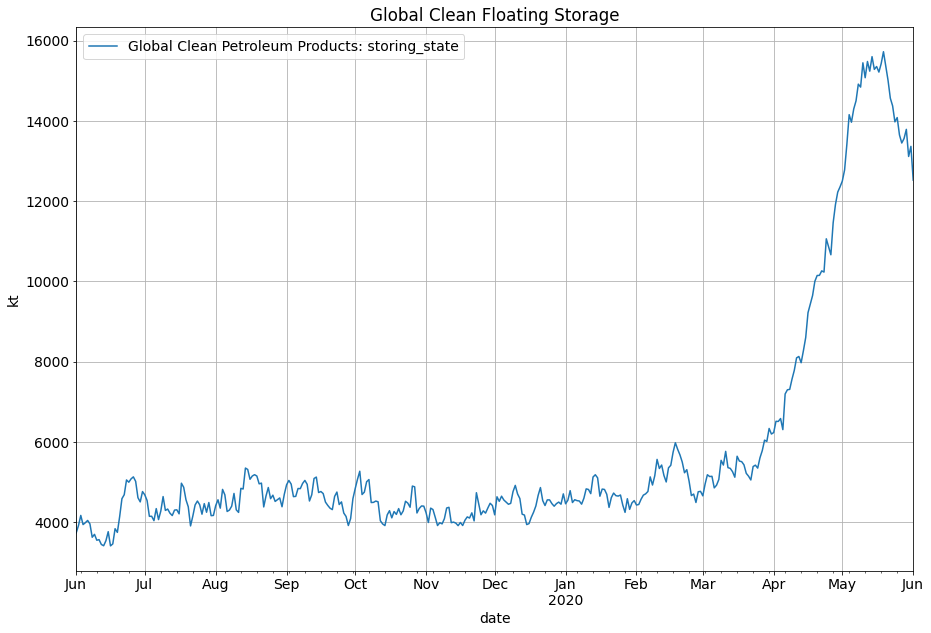

In [10]:
plot_df(clean_fs, "Global Clean Floating Storage")

In [11]:
data_frames = [
    fetch_timeseries(gasoline_blending_components),
    fetch_timeseries(diesel_gasoil),
    fetch_timeseries(naphtha),
    fetch_timeseries(jet_kero)
]

In [12]:
df_merged = merge(data_frames)
df_merged.head()

,Global Gasoline/Blending Components: storing_state,Global Diesel/Gasoil: storing_state,Global Naphtha: storing_state,Global Jet/Kero: storing_state
date,,,,
2019-06-01,732.558,1708.553,257.764,106.579
2019-06-02,809.747,1785.089,291.446,87.359
2019-06-03,988.951,1823.868,306.365,87.359
2019-06-04,1044.800,1671.668,237.912,86.408
2019-06-05,910.114,1721.669,355.552,45.720


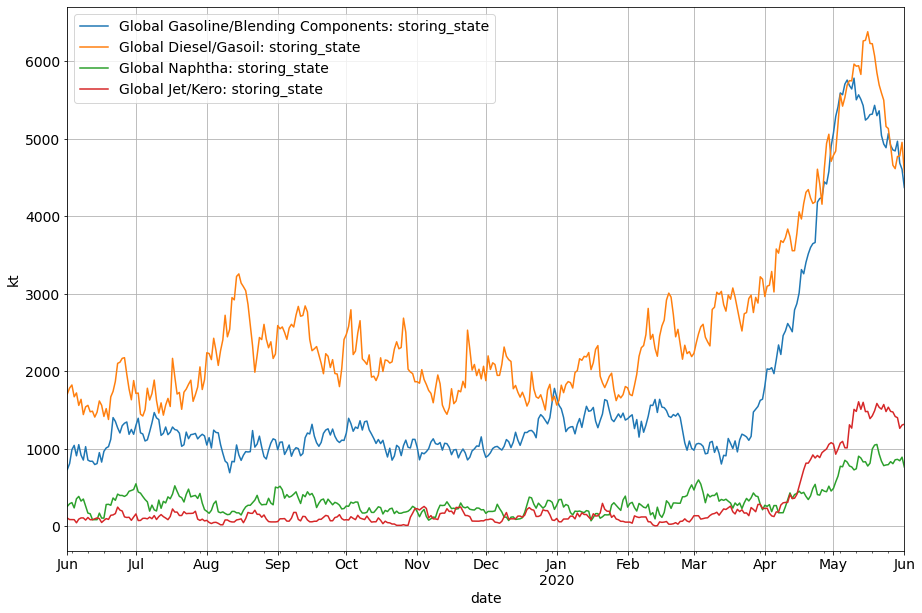

In [13]:
plot_df(df_merged)

In [14]:
countries_data_frames = [
    fetch_timeseries(clean, "China"),
    fetch_timeseries(clean, "South Korea"),
    fetch_timeseries(clean, "Japan"),
    fetch_timeseries(clean, "Singapore [SG]")
]

KeyboardInterrupt: 

In [13]:
countries_merged = merge(countries_data_frames)

In [14]:
countries_merged

,China Clean Petroleum Products: storing_state,South Korea Clean Petroleum Products: storing_state,Japan Clean Petroleum Products: storing_state,Singapore [SG] Clean Petroleum Products: storing_state
date,,,,
2019-06-01,207.328,4.102,2.018,11.407
2019-06-02,190.270,4.102,2.018,10.176
2019-06-03,158.159,4.953,2.018,24.289
2019-06-04,176.027,20.652,2.018,23.396
2019-06-05,178.771,29.544,9.663,24.896
...,...,...,...,...
2020-05-28,369.607,125.546,0.000,188.408
2020-05-29,398.722,125.546,0.000,150.122
2020-05-30,366.768,196.793,0.000,67.348


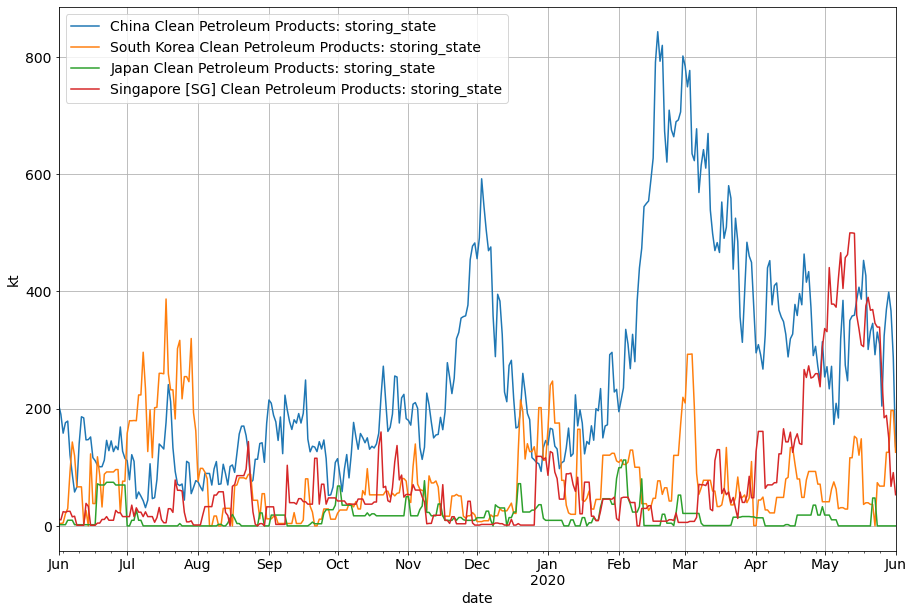

In [16]:
plot_df(countries_merged)

2020-06-04 14:50:36,438 vortexasdk.operations — INFO — Searching Products
2020-06-04 14:50:36,439 vortexasdk.client — INFO — Payload: {'term': ['Clean Petroleum Products'], 'allowTopLevelProducts': True}
2020-06-04 14:50:36,814 vortexasdk.operations — INFO — Searching Geographies
2020-06-04 14:50:36,817 vortexasdk.client — INFO — Payload: {'term': ['China']}
2020-06-04 14:50:37,047 vortexasdk.client — INFO — 13 Results to retrieve. Sending 1 post requests in parallel using 6 threads.
2020-06-04 14:50:37,474 vortexasdk.operations — INFO — Searching CargoTimeSeries
2020-06-04 14:50:37,476 vortexasdk.client — INFO — Payload: {'filter_activity': 'unloading_state', 'filter_time_min': '2019-06-01T00:00:00.000Z', 'filter_time_max': '2020-06-01T00:00:00.000Z', 'filter_products': ['b68cbb746f8b9098c50e2ba36bcad83001a53bd362e9031fb49085d02c36659c'], 'filter_destinations': ['934c47f36c16a58d68ef5e007e62a23f5f036ee3f3d1f5f85a48c572b90ad8b2'], 'disable_geographic_exclusion_rules': True, 'timeseries

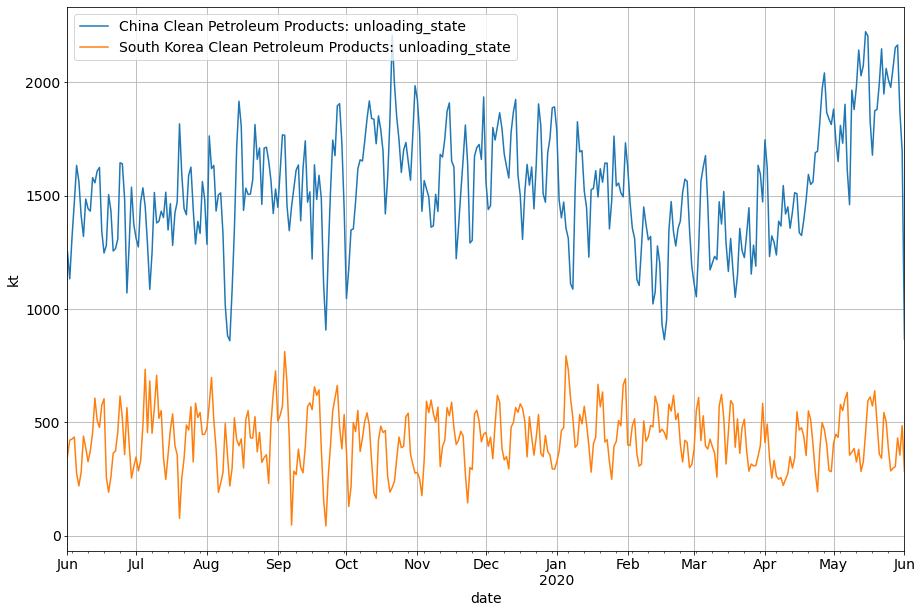

In [15]:
plot_df(merge([
    fetch_timeseries(clean, "China", "unloading_state"),
    fetch_timeseries(clean, "South Korea", "unloading_state")
]))

# Landed Cargo Movements that were previously in floating storage

In [90]:
from vortexasdk import CargoMovements, Vessels

In [91]:
china = get_geography_id_exact("China")
clean = get_product_id_exact("Clean Petroleum Products")

In [92]:
df = CargoMovements().search(
    filter_activity="unloading_start",
    filter_destinations=china,
    filter_products=clean,
    filter_time_min=datetime(2020, 1, 1),
    filter_time_max=datetime(2020, 6, 1),
    cm_unit=UNIT
).to_df('all')

Loading from API: 10500it [00:23, 446.58it/s]                           


In [93]:
# Show all available columns - useful to pick and chose which ones we're interested in
for c in sorted(df.columns):
    print(c)

cargo_movement_id
events.cargo_fso_load_event.0.end_timestamp
events.cargo_fso_load_event.0.event_type
events.cargo_fso_load_event.0.fso_vessel_id
events.cargo_fso_load_event.0.fso_vessel_name
events.cargo_fso_load_event.0.location.country.id
events.cargo_fso_load_event.0.location.country.label
events.cargo_fso_load_event.0.location.country.layer
events.cargo_fso_load_event.0.location.country.probability
events.cargo_fso_load_event.0.location.country.source
events.cargo_fso_load_event.0.location.region.id
events.cargo_fso_load_event.0.location.region.label
events.cargo_fso_load_event.0.location.region.layer
events.cargo_fso_load_event.0.location.region.probability
events.cargo_fso_load_event.0.location.region.source
events.cargo_fso_load_event.0.location.shipping_region.id
events.cargo_fso_load_event.0.location.shipping_region.label
events.cargo_fso_load_event.0.location.shipping_region.layer
events.cargo_fso_load_event.0.location.shipping_region.probability
events.cargo_fso_load_event

In [94]:
# Find all cargo movements that have been in floating storage
df_fs = df[df['events.cargo_storage_event.0.end_timestamp'].notnull()]

In [95]:
# Select the columns we're interested in and give them simpler names
column_names = {
    'events.cargo_storage_event.0.location.country.label': 'storage_country',
    'events.cargo_port_unload_event.0.location.port.label': 'discharge_port',
    'events.cargo_port_unload_event.0.location.country.label': 'discharge_country',
    'events.cargo_port_unload_event.0.start_timestamp': 'discharge_ts',
    'product.group_product.label': 'group_product',
    'product.grade.label': 'grade',
    'vessels.0.name': 'vessel.0',
    'vessels.1.name': 'vessel.1',
    'quantity': UNIT
}

df_landed = df_fs[list(column_names.keys())].rename(columns=column_names)

In [96]:
# This is our dataframe of all cargo movements that were previously in FS and have now discharged.
df_landed.head()

,storage_country,discharge_port,discharge_country,discharge_ts,group_product,grade,vessel.0,vessel.1,t
3,China,Nantong [CN],China,2020-03-08T12:17:15+0000,LPG+,NaN,MARIA III,NaN,1080
4,China,Ningbo (Beilun) [CN],China,2020-05-15T03:54:17+0000,Other Clean Products,NaN,ZHOU HAI YOU 78,NaN,11745
62,China,Ningbo (Beilun) [CN],China,2020-05-05T10:22:40+0000,Other Clean Products,NaN,NING HUA 411,NaN,8982
96,China,Zhuhai [CN],China,2020-03-06T10:00:01+0000,Other Clean Products,NaN,XING LONG ZHOU 665,NaN,12431
111,China,Nanjing [CN],China,2020-03-12T04:35:08+0000,Other Clean Products,NaN,SHEN ZHOU 3516,NaN,3077


In [97]:
df_landed.group_product.value_counts()

Other Clean Products            469
Diesel/Gasoil                    74
LPG+                             72
Biodiesel                        54
Gasoline/Blending Components     21
Naphtha                          19
Jet/Kero                         13
Name: group_product, dtype: int64

In [98]:
df_landed['discharge_date'] = pd.to_datetime(df_landed['discharge_ts']).dt.date

In [99]:
group_by_day = df_landed.groupby(by='discharge_date')['t'].sum()

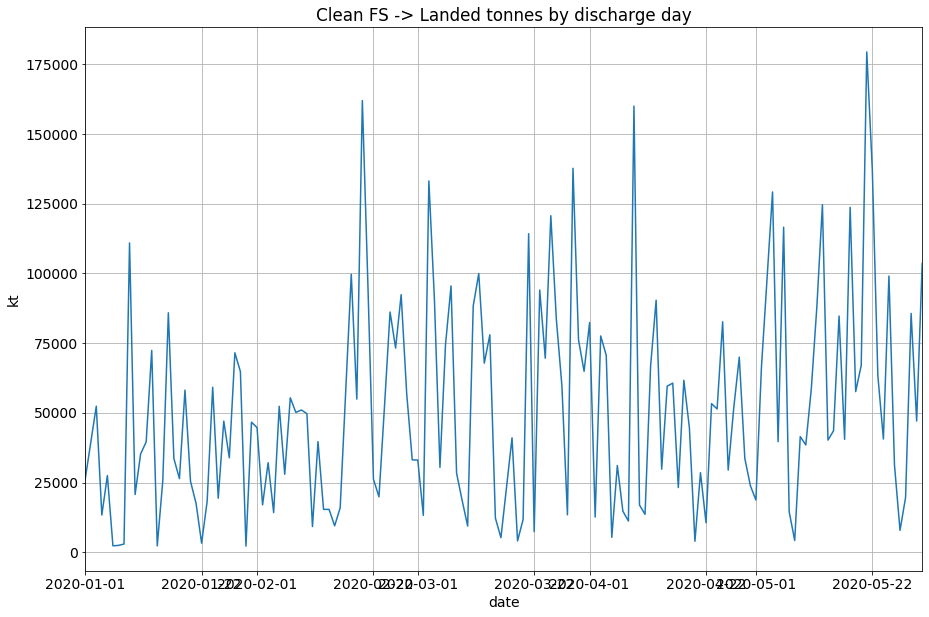

In [100]:
plot_df(group_by_day, title="Clean FS -> Landed tonnes by discharge day")